### Transformer-Encoder Prediction

## Preprocessing

Download required libraries

In [ ]:
%%capture
!sudo apt install -y fluidsynth
!pip install pretty_midi
!pip install --upgrade pyfluidsynth
!pip install spotipy
!pip install tensorflow-addons

Imports

In [ ]:
import collections
import pandas as pd
import numpy as np
import pretty_midi
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, callbacks
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from itertools import product
import matplotlib.pyplot as plt
import spotipy
from IPython import display
from spotipy.oauth2 import SpotifyClientCredentials
from google.colab import drive
import os

Download Maestro dataset

In [ ]:
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip &> /dev/null
!unzip maestro-v3.0.0-midi.zip -d . &> /dev/null
print("Files Downloaded and Unzipped [✓]")

Files Downloaded and Unzipped [✓]


Get notes from MIDI files

In [ ]:
# function modified from: https://www.tensorflow.org/tutorials/audio/music_generation
def midi_to_notes(midi_file, num_notes=100) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # return empty dataframe if midi file has less than the requested number of notes
  if len(instrument.notes) < num_notes:
    return pd.DataFrame(columns=['midi_filename', 'order', 'pitch', 'step', 'duration'])

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  # create note data
  for i, note in enumerate(sorted_notes):
    start = note.start
    end = note.end
    notes['midi_filename'].append(midi_file)
    notes['order'].append(i)
    notes['pitch'].append(note.pitch / 128)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

    if i + 1 == num_notes:
      break

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

dataset_folders = [f'maestro-v3.0.0/{folder}' for folder in os.listdir('maestro-v3.0.0') if os.path.isdir(f'maestro-v3.0.0/{folder}')] # get dataset subfolders
midi_files = [f'{folder}/{midi_file}' for folder in dataset_folders for midi_file in os.listdir(folder)] # get midi file paths

notes_df = pd.concat([midi_to_notes(midi_file) for midi_file in midi_files]) # convert midi files to tables of notes

Create Spotify API queries for each song

In [ ]:
queries_by_midi_file = {}

metadata = pd.read_csv('maestro-v3.0.0/maestro-v3.0.0.csv', index_col=False)
for _, row in metadata[['canonical_composer', 'canonical_title', 'midi_filename']].iterrows():
  queries_by_midi_file[f'maestro-v3.0.0/{row["midi_filename"]}'] = f'{row["canonical_title"]} {row["canonical_composer"]}'

Get Spotify ID for each song

In [ ]:
filenames = set(notes_df['midi_filename'].to_list())
queries = [queries_by_midi_file[filename] for filename in filenames]

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
  client_id='553fc86cc2324afcbe872ad5b40fe59a',
  client_secret='c71ddf6ab14b4b44884f4ebdf381925b'
))

spotify_ids = []
failed_indices = []
for i, query in enumerate(queries):
  response = sp.search(query, limit=1)
  if len(response['tracks']['items']) > 0:
    spotify_ids.append(response['tracks']['items'][0]['id'])
  else:
    failed_indices.append(i)

Get sentiment score for each song

In [ ]:
sentiment_scores = collections.defaultdict(list)
filenames = set(notes_df['midi_filename'].to_list())
filenames = [filename for i, filename in enumerate(filenames) if i not in failed_indices]

for id, filename in zip(spotify_ids, filenames):
  response = sp.audio_features(id)[0]
  sentiment_scores['midi_filename'].append(filename)
  sentiment_scores['danceability'].append(response['danceability'])
  sentiment_scores['energy'].append(response['energy'])
  sentiment_scores['valence'].append(response['valence'])

sentiment_scores_df = pd.DataFrame({name: np.array(value) for name, value in sentiment_scores.items()})

Save nites and sentiment scores dataframes

In [ ]:
# remove notes from songs where sentiment scores could not be found
valid_filenames = sentiment_scores_df['midi_filename'].to_list()
notes_df = notes_df[notes_df['midi_filename'].isin(valid_filenames)]

# save dataframes
!mkdir maestro_cleaned
notes_df.to_csv('maestro_cleaned/notes.csv', index=False)
sentiment_scores_df.to_csv('maestro_cleaned/sentiment_scores.csv', index=False)

Zip data and send to Google Drive

In [ ]:
!zip -r maestro_cleaned.zip maestro_cleaned
!mv maestro_cleaned.zip drive/Shareddrives/CIS\ 522\ Final\ Project/

  adding: maestro_cleaned/ (stored 0%)
  adding: maestro_cleaned/notes.csv (deflated 91%)
  adding: maestro_cleaned/sentiment_scores.csv (deflated 88%)
mv: cannot move 'maestro_cleaned.zip' to 'drive/Shareddrives/CIS 522 Final Project/': No such file or directory


## Load Dataset

Get dataset from Google Drive

In [ ]:
!unzip drive/Shareddrives/CIS\ 522\ Final\ Project/maestro_cleaned.zip -d .

unzip:  cannot find or open drive/Shareddrives/CIS 522 Final Project/maestro_cleaned.zip, drive/Shareddrives/CIS 522 Final Project/maestro_cleaned.zip.zip or drive/Shareddrives/CIS 522 Final Project/maestro_cleaned.zip.ZIP.


Load dataframes from dataset

In [ ]:
notes_df = pd.read_csv('maestro_cleaned/notes.csv')
sentiment_scores_df = pd.read_csv('maestro_cleaned/sentiment_scores.csv')

In [ ]:
notes_df.head()

,midi_filename,order,pitch,step,duration
0,maestro-v3.0.0/2006/MIDI-Unprocessed_22_R1_200...,0,0.304688,0.000000,0.145833
1,maestro-v3.0.0/2006/MIDI-Unprocessed_22_R1_200...,1,0.335938,0.054688,0.162760
2,maestro-v3.0.0/2006/MIDI-Unprocessed_22_R1_200...,2,0.359375,0.036458,0.104167
3,maestro-v3.0.0/2006/MIDI-Unprocessed_22_R1_200...,3,0.492188,0.019531,0.097656
4,maestro-v3.0.0/2006/MIDI-Unprocessed_22_R1_200...,4,0.398438,0.010417,0.078125


In [ ]:
sentiment_scores_df.head()

,midi_filename,danceability,energy,valence
0,maestro-v3.0.0/2006/MIDI-Unprocessed_12_R1_200...,0.494,0.2860,0.1350
1,maestro-v3.0.0/2018/MIDI-Unprocessed_Recital12...,0.343,0.0209,0.0393
2,maestro-v3.0.0/2008/MIDI-Unprocessed_10_R1_200...,0.283,0.1590,0.0694
3,maestro-v3.0.0/2013/ORIG-MIDI_01_7_7_13_Group_...,0.361,0.1670,0.0788
4,maestro-v3.0.0/2013/ORIG-MIDI_01_7_8_13_Group_...,0.315,0.2640,0.1390


Create datasets from dataframes

In [ ]:
# Danceability: 0 - Not Danceable, 1 - Somewhat Danceable, 2 - Very Danceable
# Energy: 0 - Not Energetic, 1 - Somewhat Energetic, 2 - Very Energetic
# Valence: 0 - Sad, 1 - Neutral, 2 - Happy
def to_class_labels(y_train, y_test):
  limits = [np.percentile(y_train, i * 33.333 + 33.333) for i in range(3)]
  y_train_classes, y_test_classes = [], []
  for y, y_classes in zip([y_train, y_test], [y_train_classes, y_test_classes]):
    for y_sample in y:
      for label, limit in enumerate(limits):
        if y_sample <= limit or (label == 2 and y_sample > limits[label - 1]):
          one_hot = [0.0] * 3
          one_hot[label] = 1.0
          y_classes.append(one_hot)
          break
  return np.array(y_train_classes), np.array(y_test_classes)

# separate data by danceability, energy, and valence
X, y_danceability, y_energy, y_valence = [], [], [], []
for _, row in sentiment_scores_df[['midi_filename', 'danceability', 'energy', 'valence']].iterrows():
  notes = notes_df[notes_df['midi_filename'] == row['midi_filename']][['pitch', 'step', 'duration']]
  X.append(notes)
  y_danceability.append(row['danceability'])
  y_energy.append(row['energy'])
  y_valence.append(row['valence'])

# split data into train and test sets
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(np.array(X), np.array(y_danceability), test_size=0.2)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(np.array(X), np.array(y_energy), test_size=0.2)
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(np.array(X), np.array(y_valence), test_size=0.2)

# assign class labels
y_train_d, y_test_d = to_class_labels(y_train_d, y_test_d)
y_train_e, y_test_e = to_class_labels(y_train_e, y_test_e)
y_train_v, y_test_v = to_class_labels(y_train_v, y_test_v)

In [ ]:
X_train_d.shape

(850, 100, 3)

In [ ]:
X_test_d.shape

(213, 100, 3)

In [ ]:
y_train_d.shape

(850, 3)

In [ ]:
X_train_e.shape

(850, 100, 3)

In [ ]:
y_train_d[0:5]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [ ]:
y_train_e[0:5]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

## Transformer

Imports

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import copy
import time
import pdb
import math
from itertools import cycle

Construct DataLoaders

In [ ]:
X_train_d_loader = DataLoader(X_train_d, batch_size = 32)
X_train_e_loader = DataLoader(X_train_e, batch_size = 32)
X_train_v_loader = DataLoader(X_train_v, batch_size = 32)

In [ ]:
y_train_d_loader = DataLoader(y_train_d, batch_size = 32)
y_train_e_loader = DataLoader(y_train_e, batch_size = 32)
y_train_v_loader = DataLoader(y_train_v, batch_size = 32)

In [ ]:
X_test_d_loader = DataLoader(X_test_d, batch_size = 32)
X_test_e_loader = DataLoader(X_test_e, batch_size = 32)
X_test_v_loader = DataLoader(X_test_v, batch_size = 32)

In [ ]:
y_test_d_loader = DataLoader(y_test_d, batch_size = 32)
y_test_e_loader = DataLoader(y_test_e, batch_size = 32)
y_test_v_loader = DataLoader(y_test_v, batch_size = 32)

"Embedding," Which is a Linear Layer

In [ ]:
class Embedder(nn.Module):
  def __init__(self, atts_length, d_model):
    super().__init__()
    
    # Attributes length is 3 for our preprocessing
    self.fc = nn.Linear(atts_length, d_model)

  def forward(self, x):
    return self.fc(x.float())

Positional Encoder

In [ ]:
class PositionalEncoder(nn.Module):
  
  def __init__(self, d_model, max_seq_len = 100):
    super().__init__()
    self.d_model = d_model

    # create pe matrix
    pe = torch.zeros(max_seq_len, d_model)
    for pos in range(max_seq_len):
      for i in range (0, d_model, 2):
        pe[pos, i] = math.sin(pos / (10000 ** ((2 * i) / d_model)))
        pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * i) / d_model)))

    pe = pe.unsqueeze(0)
    self.register_buffer("pe", pe)

  def forward(self, x):
    
    # add position info to embedding
    x = x * math.sqrt(self.d_model)

    # add constant to embedding
    seq_len = x.shape[1]
    x = x + Variable(self.pe[:,:seq_len], requires_grad = False)

    return x

Output Layer

In [ ]:
class Output(nn.Module):
  def __init__(self, seq_len, d_model, hidden_size = 100):
    super().__init__()
    
    self.d_model = d_model
    self.hidden_size = hidden_size
    
    self.fc1 = nn.Linear(seq_len * d_model, hidden_size)
    self.fc2 = nn.Linear(hidden_size, 3)

    self.relu = nn.ReLU()

  def forward(self, x):
    
    # used when decoder is used
    # fc1 = nn.Linear(self.d_model * x.shape[0], self.hidden_size)
    
    # Flatten, excluding batch dim
    x = x.reshape(x.shape[0], -1)

    x = self.fc1(x)
    #x = self.relu(x)
    x = self.fc2(x)
    #x = self.relu(x)

    return x

Multi-Head Attention

In [ ]:
class MHA(nn.Module):
  def __init__(self, heads, d_model, dropout = 0.1):
    super().__init__()
    
    # Number of heads running attention concurrently
    self.heads = heads

    # Model dimensionality: hidden dim size of value, key, query
    self.d_model = d_model

    # Model dimensionality per head (V,K,Q split between heads along this dim)
    self.d_k = d_model // heads

    # Linear layers for producing V,K,Q
    self.v_fc = nn.Linear(d_model, d_model)
    self.k_fc = nn.Linear(d_model, d_model)
    self.q_fc = nn.Linear(d_model, d_model)

    self.dropout = nn.Dropout(p = dropout)

    # Linear layer for producing final prediction
    self.out = nn.Linear(d_model, d_model)

  def forward(self, q, k, v):

    batch_size = q.shape[0]

    # Calc value, key, query, as linear layer outputs
    v = self.v_fc(v).view(batch_size, -1, self.heads, self.d_k)
    k = self.k_fc(k).view(batch_size, -1, self.heads, self.d_k)
    q = self.q_fc(q).view(batch_size, -1, self.heads, self.d_k)

    k, q, v = k.transpose(1,2), q.transpose(1,2), v.transpose(1,1)

    # Calculate attention (mask will work differently here!)
    scores = attention(q, k, v, self.d_k)

    # Concat heads and put through output layer to make predictions
    concat = scores.transpose(1,2).contiguous().view(batch_size, -1, self.d_model)
    output = self.out(concat)

    return output

Attention

In [ ]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    
    ## This will likely need to be changed

    # Query * Key
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)

    # Masking (not implemented)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)

    # Preparing for Value calc
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
    
    # Score * Value (how well does each query align w/each key)
    output = torch.matmul(scores, v.transpose(2,1))

    return output

Feed-Forward Network

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, d_model, d_hidden= 2048, dropout = 0.1):
    super().__init__()

    # Normal feed-forward net . . . will output d_model
    self.fc1 = nn.Linear(d_model, d_hidden)
    self.dropout = nn.Dropout(p = dropout)
    self.fc2 = nn.Linear(d_hidden, d_model)

    self.relu = nn.ReLU()

  def forward(self, x):

    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    
    return x

Normalization

In [ ]:
class Norm(nn.Module):
  def __init__(self, d_model, eps = 1e-6):

    super().__init__()

    self.d_model = d_model

    # Initialize learnable normalization parameters alpha and beta
    self.alpha = nn.Parameter(torch.ones(self.d_model))
    self.beta = nn.Parameter(torch.zeros(self.d_model))
    self.eps = eps

  def forward(self, x):
    
    # Subtract mean to get deviation, devide by stdev and add bias beta
    x = self.alpha * (x - x.mean(dim = -1, keepdim = True)) / (x.std(dim = -1, keepdim = True) + self.eps) + self.beta

    return x

Encoder Layer & Encoder

In [ ]:
class EncoderLayer(nn.Module):

  def __init__(self, d_model, heads, dropout = 0.5):
    super().__init__()

    # Network Layers
    self.attn = MHA(heads, d_model)
    self.ff = FeedForward(d_model)

    # Normalization & Dropout
    self.n1 = Norm(d_model)
    self.n2 = Norm(d_model)
    self.d1 = nn.Dropout(dropout)
    self.d2 = nn.Dropout(dropout)

  def forward(self, x, mask = None):
    
    # Input normalization
    x2 = self.n1(x)

    # Attention Layer (query, key, value all start the same) with residual addition
    x3 = self.attn(x2, x2, x2)
    x = x + self.d1(x3)

    # Attention normalization
    x2 = self.n2(x)

    # Feedforward Layer with residual addition
    x3 = self.ff(x2)
    x = x + self.d2(x3)

    return x

In [ ]:
class Encoder(nn.Module):

  def __init__(self, size, d_model, n, heads):
    super().__init__()

    # Define positional encoder
    self.pe = PositionalEncoder(d_model)

    # Number of encoders in the encoder stack
    self.n = n

    # Midi embedding (different from normal NLP embedding)
    self.embed = Embedder(size, d_model)

    # Generate stack of "n" encoder layers
    self.layers = get_clones(EncoderLayer(d_model, heads), n)

    # Normalization layer
    self.norm = Norm(d_model)

  def forward(self, x, mask = None, verbose = False):

    if verbose:
        print("encoding . . .")

    # Embed note attributes
    x = self.embed(x)

    # Add position information
    x = self.pe(x)

    # Send value through encoder stack
    for i in range(n):
      x = self.layers[i](x)

    # Normalize output
    x = self.norm(x)

    return x

Decoder Layer & Decoder

In [ ]:
class DecoderLayer(nn.Module):

  def __init__(self, d_model, heads, dropout = 0.5):
    super().__init__()

    # Network Layers (two attentions, one using encoder values for key value)
    self.attn1 = MHA(heads, d_model)
    self.attn2 = MHA(heads, d_model)
    self.ff = FeedForward(d_model)

    # Normalization & Dropout
    self.n1 = Norm(d_model)
    self.n2 = Norm(d_model)
    self.n3 = Norm(d_model)
    self.d1 = nn.Dropout(dropout)
    self.d2 = nn.Dropout(dropout)
    self.d3 = nn.Dropout(dropout)

  def forward(self, x, e_outputs, src_mask = None, trg_mask = None):

    # Input normalization
    x2 = self.n1(x)

    # Attention Layer (query, key, value all start the same) with residual addition
    x3 = self.attn1(x2, x2, x2)
    x = x + self.d1(x3)

    # Attention normalization
    x2 = self.n2(x)

    # Attention Layer (incorperates encoder outputs) with residual addition
    x3 = self.attn2(x2, e_outputs, e_outputs)
    x = x + self.d2(x3)

    # Attention normalization
    x2 = self.n3(x)

    # Feedforward Layer with residual addition
    x3 = self.ff(x2)
    x = x + self.d2(x3)

    return x

In [ ]:
class Decoder(nn.Module):

  def __init__(self, size, d_model, n, heads):
    super().__init__()

    # Number of encoders in the encoder stack
    self.n = n

    # Midi embedding (different from normal NLP embedding)
    self.embed = Embedder(size, d_model)

    # Generate stack of "n" decoder layers
    self.layers = get_clones(DecoderLayer(d_model, heads), n)

    # Normalization layer
    self.norm = Norm(d_model)

  def forward(self, x, e_outputs, src_mask = None, trg_mask = None, verbose = False):
    
    if verbose:
      print("decoding . . .")

    # Embed note attributes
    x = self.embed(x)

    # Send value through decoder stack
    for i in range(n):
      x = self.layers[i](x, e_outputs)

    # Normalize output
    x = self.norm(x)

    return x

Cloning Method

In [ ]:
def get_clones(module, n):
  ''' Use list comprehension to create stacks of networks layers '''
  return nn.ModuleList([copy.deepcopy(module) for i in range(n)])

Transformer (Full Implemented)

In [ ]:
class Transformer(nn.Module):

  def __init__(self, src_att, trg_att, d_model, N, heads):
    super().__init__()

    # Source attributes are initial three or three + harmony infomation (12 tones, one-hot). Target should always be one
    self.encoder = Encoder(src_att, d_model, n, heads)
    self.decoder = Decoder(trg_att, d_model, n, heads)
    self.out = Output(100, d_model)

    # get lengths of source, target seqs
    self.src_att = src_att
    self.trg_att = trg_att

  def forward(self, src, trg, verbose = False):
    
    if verbose:
      print('starting forward pass')

    e_outputs = self.encoder(src)
    #d_outputs = self.decoder(trg, e_outputs)
    output = self.out(e_outputs)

    if verbose:
      print('finishing forward pass')

    return output

Training

In [ ]:
def train_model(model, X_train_loader, y_train_loader, X_test_loader, y_test_loader, epochs):
    
    model.train()
    
    start = time.time()
    temp = start
    
    total_loss = 0
    loss_avg = 0
    n_correct = 0
    n_total = 0

    # Track train, test loss, accuracy
    train_acc_list = []
    train_loss_list = []
    test_acc_list = []
    test_loss_list = []
    
    for epoch in range(epochs):
       
        for i, (batch, labels) in enumerate(zip(cycle(X_train_loader), y_train_loader)):
            src = batch
            trg = labels
            
            # src_mask, trg_mask = create_masks(src, trg_input)
            
            preds = model(src, trg)
            
            optim.zero_grad()
            
            #pdb.set_trace()
            loss = F.cross_entropy(preds, trg)
            #pdb.set_trace()
            loss.backward()
            #pdb.set_trace()
            optim.step()
            #pdb.set_trace()    
            total_loss += loss.data
            #pdb.set_trace()

            # Ordinal model predictions
            pred_classes = torch.argmax(preds, dim = 1)
            trg_classes = torch.argmax(trg, dim = 1)
            #pdb.set_trace()

            # Compile correct/incorrect for accuracy calc
            n_correct += sum(pred_classes == trg_classes)
            n_total += batch.shape[0]

        train_acc = n_correct/n_total
        train_loss = total_loss/i

        # Check test accuracy
        test_loss, test_acc, _, _ = test_model(model, X_test_loader, y_test_loader, verbose = False)

        print("time = %dm, epoch %d, loss/batch = %.3f, training accuracy = %.3f, test accuracy = %0.3f, %ds/epoch" % ((time.time() - start) // 60,\
        epoch + 1, train_loss, train_acc, test_acc, time.time() - temp))

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)

        total_loss = 0
        n_correct = 0
        n_total = 0

        temp = time.time()

    return train_acc_list, train_loss_list, test_acc_list, test_loss_list    

In [ ]:
def test_model(model, X_test_loader, y_test_loader, verbose = True):

  model.eval()

  n_correct = 0
  n_total = 0
  total_loss = 0

  pred_classes_list = []
  trg_classes_list = []

  for i, (batch, labels) in enumerate(zip(cycle(X_test_loader), y_test_loader)):
    src = batch
    trg = labels

    # Probabilistic model predictions
    preds = model(src, trg)

    # CE Loss
    loss = F.cross_entropy(preds, trg)
    total_loss += loss.data

    # Ordinal model predictions
    pred_classes = torch.argmax(preds, dim = 1)
    trg_classes = torch.argmax(trg, dim = 1)
    
    pred_classes_list = pred_classes_list + pred_classes.toList()
    trg_classes_list = trg_classes_list + trg_classes.toList()

    # Compile correct/incorrect for accuracy calc
    n_correct += sum(pred_classes == trg_classes)
    n_total += batch.shape[0]
    #pdb.set_trace()

  accuracy = n_correct/n_total
  avg_loss = total_loss/i

  if verbose:
    print(f"Average loss: {avg_loss}")
    print(f"Accuracy: {accuracy}")

  return avg_loss, accuracy, pred_classes_list, trg_classes_list

Energy (~80 mins)

In [ ]:
X_train = X_train_e

# Define hyperparameters
d_model, heads, n = 64,8,4
src_att = X_train.shape[2]
trg_att = 3

# Build model
eng_model = Transformer(src_att, trg_att, d_model, n, heads)

# Initialize model
for p in eng_model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Construct Optimizer
optim = torch.optim.Adam(eng_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
train_acc_list_e, train_loss_list_e, test_acc_list_e, test_loss_list_e \
= train_model(eng_model, X_train_e_loader, y_train_e_loader, X_test_e_loader, y_test_e_loader, epochs = 200)

time = 0m, epoch 1, loss/batch = 1.826, training accuracy = 0.360, test accuracy = 0.371, 28s/epoch
time = 0m, epoch 2, loss/batch = 1.115, training accuracy = 0.449, test accuracy = 0.423, 23s/epoch
time = 1m, epoch 3, loss/batch = 1.006, training accuracy = 0.519, test accuracy = 0.488, 25s/epoch
time = 1m, epoch 4, loss/batch = 0.937, training accuracy = 0.576, test accuracy = 0.512, 24s/epoch
time = 2m, epoch 5, loss/batch = 0.890, training accuracy = 0.595, test accuracy = 0.531, 23s/epoch
time = 2m, epoch 6, loss/batch = 0.822, training accuracy = 0.635, test accuracy = 0.563, 23s/epoch
time = 2m, epoch 7, loss/batch = 0.769, training accuracy = 0.679, test accuracy = 0.535, 24s/epoch
time = 3m, epoch 8, loss/batch = 0.737, training accuracy = 0.691, test accuracy = 0.521, 24s/epoch
time = 3m, epoch 9, loss/batch = 0.713, training accuracy = 0.694, test accuracy = 0.516, 24s/epoch
time = 4m, epoch 10, loss/batch = 0.710, training accuracy = 0.692, test accuracy = 0.498, 23s/epoch

Danceability (~80 mins)

In [ ]:
X_train = X_train_d

# Define hyperparameters
d_model, heads, n = 64,8,4
src_att = X_train.shape[2]
trg_att = 3

# Build model
dnc_model = Transformer(src_att, trg_att, d_model, n, heads)

# Initialize model
for p in dnc_model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Construct Optimizer
optim = torch.optim.Adam(dnc_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
train_acc_list_d, train_loss_list_d, test_acc_list_d, test_loss_list_d \
= train_model(dnc_model, X_train_d_loader, y_train_d_loader, X_test_d_loader, y_test_d_loader, epochs = 200)

time = 0m, epoch 1, loss/batch = 1.560, training accuracy = 0.371, test accuracy = 0.357, 28s/epoch
time = 0m, epoch 2, loss/batch = 1.256, training accuracy = 0.366, test accuracy = 0.357, 24s/epoch
time = 1m, epoch 3, loss/batch = 1.155, training accuracy = 0.418, test accuracy = 0.362, 23s/epoch
time = 1m, epoch 4, loss/batch = 1.091, training accuracy = 0.447, test accuracy = 0.371, 24s/epoch
time = 2m, epoch 5, loss/batch = 1.082, training accuracy = 0.460, test accuracy = 0.371, 24s/epoch
time = 2m, epoch 6, loss/batch = 1.037, training accuracy = 0.486, test accuracy = 0.371, 24s/epoch
time = 2m, epoch 7, loss/batch = 0.998, training accuracy = 0.502, test accuracy = 0.376, 24s/epoch
time = 3m, epoch 8, loss/batch = 0.952, training accuracy = 0.536, test accuracy = 0.385, 24s/epoch
time = 3m, epoch 9, loss/batch = 0.913, training accuracy = 0.561, test accuracy = 0.394, 24s/epoch
time = 4m, epoch 10, loss/batch = 0.876, training accuracy = 0.588, test accuracy = 0.376, 24s/epoch

Valence (~80 mins)

In [ ]:
X_train = X_train_v

# Define hyperparameters
d_model, heads, n = 64,8,4
src_att = X_train.shape[2]
trg_att = 3

# Build model
val_model = Transformer(src_att, trg_att, d_model, n, heads)

# Initialize model
for p in val_model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Construct Optimizer
optim = torch.optim.Adam(val_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
train_acc_list_v, train_loss_list_v, test_acc_list_v, test_loss_list_v \
= train_model(val_model, X_train_v_loader, y_train_v_loader, X_test_v_loader, y_test_v_loader, epochs = 200)

time = 0m, epoch 1, loss/batch = 1.688, training accuracy = 0.344, test accuracy = 0.399, 28s/epoch
time = 0m, epoch 2, loss/batch = 1.128, training accuracy = 0.435, test accuracy = 0.413, 24s/epoch
time = 1m, epoch 3, loss/batch = 1.106, training accuracy = 0.448, test accuracy = 0.418, 24s/epoch
time = 1m, epoch 4, loss/batch = 1.010, training accuracy = 0.513, test accuracy = 0.418, 24s/epoch
time = 2m, epoch 5, loss/batch = 0.962, training accuracy = 0.545, test accuracy = 0.432, 24s/epoch
time = 2m, epoch 6, loss/batch = 0.903, training accuracy = 0.586, test accuracy = 0.479, 23s/epoch
time = 2m, epoch 7, loss/batch = 0.848, training accuracy = 0.612, test accuracy = 0.516, 23s/epoch
time = 3m, epoch 8, loss/batch = 0.805, training accuracy = 0.645, test accuracy = 0.521, 23s/epoch
time = 3m, epoch 9, loss/batch = 0.774, training accuracy = 0.665, test accuracy = 0.479, 23s/epoch
time = 4m, epoch 10, loss/batch = 0.725, training accuracy = 0.700, test accuracy = 0.521, 24s/epoch

Graphics

In [ ]:
def plot_metrics(metrics_d, metrics_e, metrics_v):
  fig, axs = plt.subplots(2, 3, figsize=(20, 10))
  axs = [[axs[0][i], axs[1][i]] for i in range(3)]
  metrics = [
    ('Danceability', metrics_d),
    ('Energy', metrics_e),
    ('Valence', metrics_v)
  ]

  for (target_name, target_metrics), (ax1, ax2) in zip(metrics, axs):
    ax1.set_title(f'{target_name} Loss')
    ax1.plot(target_metrics['loss'],)
    ax1.plot(target_metrics['val_loss'])
    ax1.legend(['train', 'test'])

    ax2.set_title(f'{target_name} Accuracy')
    ax2.plot(target_metrics['accuracy'])
    ax2.plot(target_metrics['val_accuracy'])
    ax2.legend(['train', 'test'])

  plt.show()


In [ ]:
# Reformat accuracy, loss, lists into dataframes

metrics_d = pd.DataFrame(columns = ["loss", "val_loss", "accuracy", "val_accuracy"])
metrics_e = pd.DataFrame(columns = ["loss", "val_loss", "accuracy", "val_accuracy"])
metrics_v = pd.DataFrame(columns = ["loss", "val_loss", "accuracy", "val_accuracy"])

metrics_d["loss"], metrics_d["val_loss"], metrics_d["accuracy"], metrics_d["val_accuracy"] \
= train_loss_list_d, test_loss_list_d, train_acc_list_d, test_acc_list_d

metrics_e["loss"], metrics_e["val_loss"], metrics_e["accuracy"], metrics_e["val_accuracy"] \
= train_loss_list_e, test_loss_list_e, train_acc_list_e, test_acc_list_e

metrics_v["loss"], metrics_v["val_loss"], metrics_v["accuracy"], metrics_v["val_accuracy"] \
= train_loss_list_v, test_loss_list_v, train_acc_list_v, test_acc_list_v

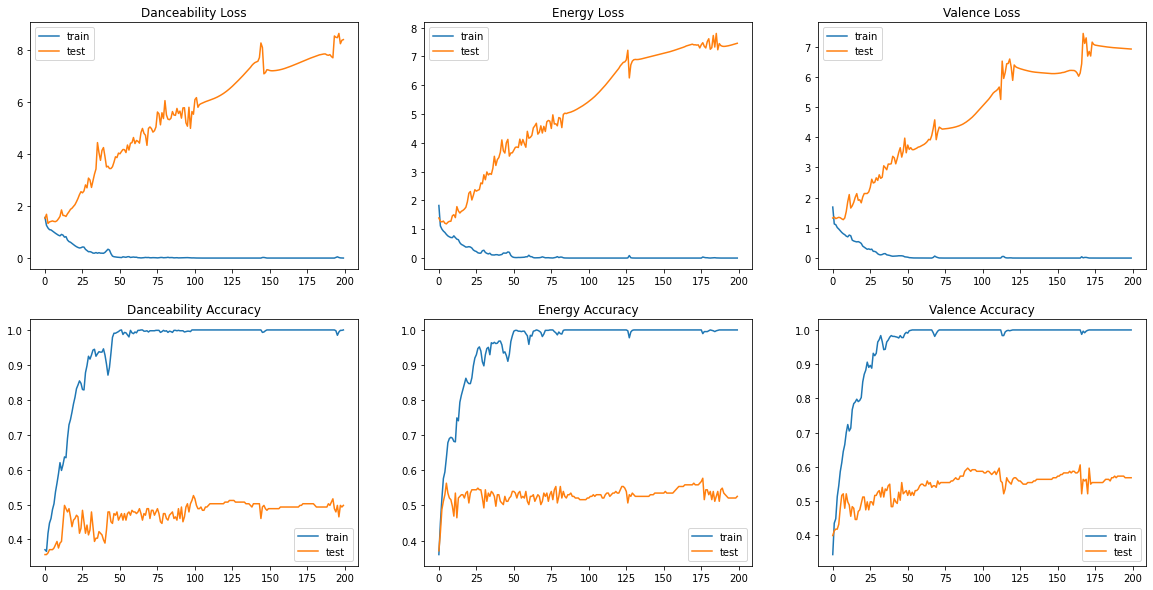

In [ ]:
plot_metrics(metrics_d, metrics_e, metrics_v)

In [ ]:
def plot_confusion_matrix_grid(y_true_d, y_pred_d, y_true_e, y_pred_e, y_true_v, y_pred_v, logits=False):
  fig, axs = plt.subplots(3, 3, figsize=(16, 16))

  if logits:
    y_true_d = np.argmax(y_true_d, axis=1)
    y_true_e = np.argmax(y_true_e, axis=1)
    y_true_v = np.argmax(y_true_v, axis=1)
    y_pred_d = np.argmax(y_pred_d, axis=1)
    y_pred_e = np.argmax(y_pred_e, axis=1)
    y_pred_v = np.argmax(y_pred_v, axis=1)

  data = [
    ('Danceability', y_true_d, y_pred_d),
    ('Energy', y_true_e, y_pred_e),
    ('Valence', y_true_v, y_pred_v)
  ]

  for (target_name, y_true, y_pred), ax_row in zip(data, axs):
    for normalize, ax in zip([None, 'true', 'pred'], ax_row):
      cmat = confusion_matrix(y_true, y_pred, normalize=normalize)
      cmat_display = ConfusionMatrixDisplay(cmat)
      cmat_display.plot(ax=ax)
      cmat_type = ' (Precision)' if normalize == 'pred' else (' (Recall)' if normalize == 'true' else '')
      ax.set_title(f'{target_name} Conf Matrix {cmat_type}')
  plt.show()

In [ ]:
# Get lists of all test predictions for all tasks
_, _, d_pred, d_trg = test_model(dnc_model, X_test_d_loader, y_test_d_loader, verbose = True)
_, _, e_pred, e_trg = test_model(eng_model, X_test_e_loader, y_test_e_loader, verbose = True)
_, _, v_pred, v_trg = test_model(val_model, X_test_v_loader, y_test_v_loader, verbose = True)

In [ ]:
plot_confusion_matrix_grid(d_trg, d_pred, e_trg, e_pred, v_trg, v_pred)